# Benchmarking spatial mapping of cell types in the LN

## Loading packages

In [1]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import pandas as pd

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
cell2location

<module 'cell2location' from '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/cell2location/__init__.py'>

## 1. Loading cell2location results <a name="loading"></a>

In [3]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lymph_nodes_analysis/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

scvi_run_name = 'signatures_lr0002_Adam_20kiter_c2l'
scvi_ref_run_name = 'signatures_lr0002_Adam_ref'
scvi_run_path = f'/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/scvi/external/cell2location/tutorial/results/lymph_nodes_analysis/non_amortised/{scvi_run_name}/'
scvi_ref_run_path = f'/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/scvi/external/cell2location/tutorial/results/lymph_nodes_analysis/non_amortised/{scvi_ref_run_name}/'

# path for saving figures
fig_path = f'{scvi_run_path}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

adata_vis = sc.read_h5ad(f'{scvi_run_path}sp.h5ad')

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

adata_snrna_raw = sc.read_h5ad(f'{scvi_ref_run_path}sc.h5ad')
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    regr_inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    regr_inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
regr_inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
regr_inf_aver.iloc[0:5, 0:5]

,B_Cycling,B_GC_DZ,B_GC_LZ,B_GC_prePB,B_IFN
ENSG00000188976,0.286211,0.183432,0.229675,0.269630,0.125889
ENSG00000188290,0.001551,0.000477,0.000556,0.041313,0.034876
ENSG00000187608,0.256078,0.167128,0.208980,0.415600,3.244958
ENSG00000186891,0.011823,0.000615,0.041789,0.052284,0.008038
ENSG00000186827,0.004274,0.000387,0.004441,0.023630,0.009090


## 2. Loading gold standard annotations results <a name="loading2"></a>

In [4]:
# read region annotation for each location
run_name = 'CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001'
manual_GC_annot = pd.read_csv(f'{sp_results_folder}{run_name}/manual_GC_annot.csv', index_col=0)
manual_GC_annot['GC'][manual_GC_annot['GC'].isna()] = 'other'
manual_GC_annot['GC'].value_counts()

other    3657
GC        378
Name: GC, dtype: int64

In [5]:
ind = manual_GC_annot.index.isin(adata_vis.obs_names)
ind = manual_GC_annot.index[ind]
adata_vis = adata_vis[ind,:]
adata_vis.obs['supervised_region'] = manual_GC_annot.loc[ind, 'GC']

# remove other group
#adata_vis = adata_vis[~adata_vis.obs['supervised_region'].isin(['other']),:]

# read region annotations for each cell type
gold_standard = pd.read_csv(f'{sp_results_folder}{run_name}/gold_standard_annotation_subtypes_to_regions.csv',
                            index_col=0)
gold_standard = gold_standard.loc[gold_standard.isna().sum(1) == 0,]
gold_standard.index = [f'gold_standard_{i}' for i in gold_standard.index]

# remove other group
gold_standard = gold_standard.loc[~gold_standard['label'].isin(['other', 'T-cell zone']),:]

for ct in gold_standard.index:
    adata_vis.obs[ct] = adata_vis.obs['supervised_region'].isin([gold_standard.loc[ct, 'label']]).astype(float)
    
adata_vis.obs[gold_standard.index]

Trying to set attribute `.obs` of view, copying.


,gold_standard_B_Cycling,gold_standard_B_GC_DZ,gold_standard_B_GC_LZ,gold_standard_B_GC_prePB,gold_standard_FDC,gold_standard_T_CD4+_TfH_GC
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0
AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTGTATTACACG-1,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
import matplotlib.patches as patches
from mpl_toolkits.axes_grid.inset_locator import inset_axes as inset_axes_func


def add_rectange_to_axis(ax, crop_coord, **kwargs):
    width = crop_coord[1] - crop_coord[0]
    height = crop_coord[2] - crop_coord[3]
    bottom_left = (crop_coord[0], crop_coord[3])
    
    kwargs = {'linewidth': 3,
             'edgecolor': 'r',
             'facecolor': 'none',
             'zorder': 10,
             **kwargs}
    
    rect = patches.Rectangle(bottom_left, width, height, **kwargs)
    ax.add_patch(rect)

def add_rectangle_to_fig(fig, crop_coord, **kwargs):
    for ax in fig:
        if type(ax.get_aspect()) is str or ax.get_aspect() < 5:
            add_rectange_to_axis(ax, crop_coord, **kwargs)

... storing 'supervised_region' as categorical


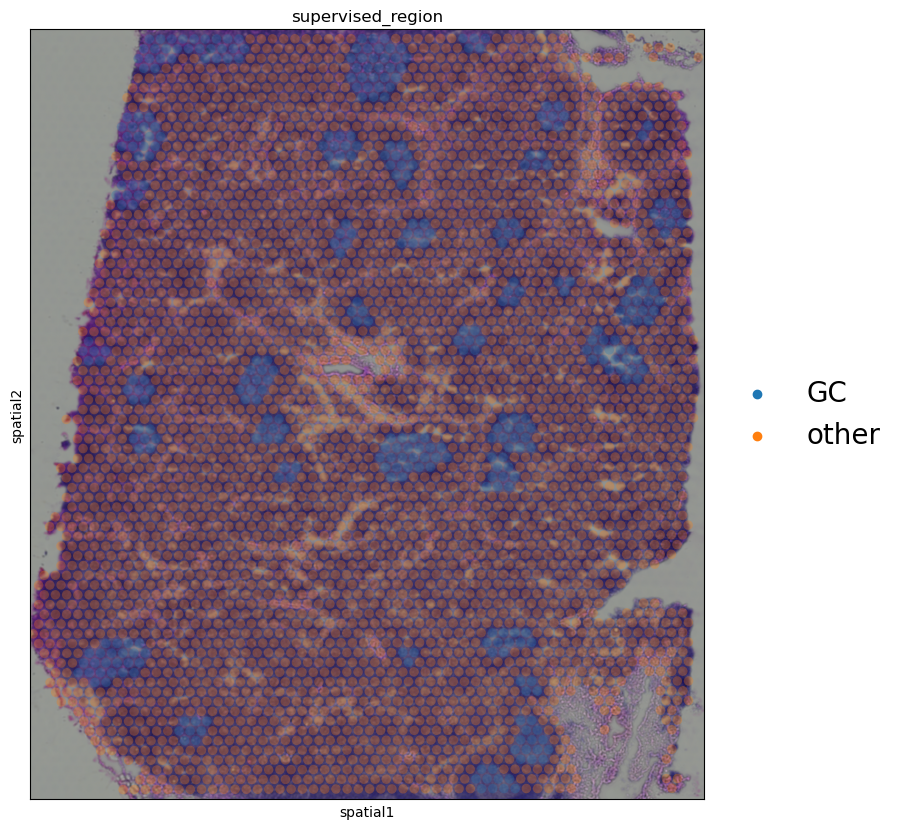

In [7]:
hires_scalef = 1/adata_vis.uns['spatial']['V1_Human_Lymph_Node']['scalefactors']['tissue_hires_scalef']
    
crop_x = np.array([230, 1640]) * hires_scalef
crop_y = [150, 1760]
#crop_y = (list(adata_vis.uns['spatial'].values())[0]['images']['hires'].shape[0]* hires_scalef - np.array(crop_y)* hires_scalef) 

crop_x_small = np.array([810, 1200]) * hires_scalef
crop_y_small = (list(adata_vis.uns['spatial'].values())[0]['images']['hires'].shape[0]* hires_scalef - np.array([1850, 1450])* hires_scalef) 
coord_small = list(crop_x_small) + list(crop_y_small)

max_y = list(adata_vis.uns['spatial'].values())[0]['images']['hires'].shape[1]
crop_y = [(max_y - i - 10) * hires_scalef for i in crop_y]

img_shape = np.array(list(adata_vis.uns['spatial'].values())[0]['images']['hires'].shape) * hires_scalef

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

with mpl.rc_context({'figure.figsize': (10, 10), 'axes.facecolor': "black"}):
    fig=sc.pl.spatial(adata_vis, cmap='magma',
                  color=['supervised_region'], ncols=4, 
                  size=1.3, img_key='hires', 
                  alpha_img=1, alpha=0.3,
                  frameon=True, legend_fontsize=20,
                  crop_coord=[crop_x[0]] + [crop_x[1]] 
                      + [crop_y[1]] + [crop_y[0]],
                  vmin=0, vmax='p99.5', #save='benchmark_supervised_region.pdf',,
                  return_fig=True, show=False,
                  #palette=sc.pl.palettes.default_102
                 )
    add_rectangle_to_fig(fig, np.array([coord_small[0], coord_small[1], 
                                   img_shape[1] - coord_small[2] + (img_shape[1] - crop_y[0]), 
                                   img_shape[1] - coord_small[3] + (img_shape[1] - crop_y[0])])/hires_scalef,
                             edgecolor='white', linestyle='--', linewidth=0)
    #fig[0].savefig(f'{fig_path}benchmark_supervised_region.pdf',
    #                bbox_inches='tight', facecolor='white')
    fig
    plt.show()

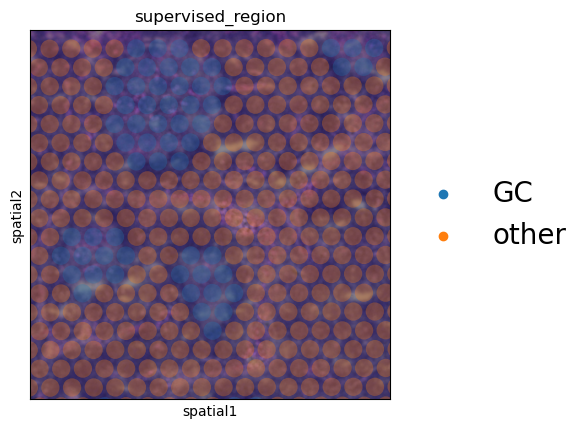

In [8]:
sc.pl.spatial(adata_vis, cmap='magma',
                  color=['supervised_region'], ncols=4, 
                  size=1.3, img_key='hires', 
                  alpha_img=1, alpha=0.3,
                  frameon=True, legend_fontsize=20,
                      vmin=0, vmax='p99.5', #save=f'benchmark_supervised_region_cropped.pdf',
                      crop_coord=coord_small
                     )

## Compare methods using PR-curves

In [9]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate

with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']


def compute_precision_recall(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = precision_recall_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = average_precision_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = average_precision_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = precision_recall_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def compute_roc(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot ROC curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = roc_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = roc_auc_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = roc_auc_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = roc_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def plot_precision_recall(pos_cell_count, infer_cell_proportions,
                          title='', iso_f1_curves=False,
                          individual_cell_types=True,
                          save=None, mode='macro', curve='PR'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    :param title: plot title
    :param iso_f1_curves: plot iso curves for F1 score?
    :param individual_cell_types: show precision-recall curves for each cell type?
    """
    
    ### calculating ###
    if curve == 'PR':
        precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions, 
                                                                        mode=mode)
        xlabel = 'Recall'
        ylabel = 'Precision'
        
    elif curve == 'ROC':
        recall, precision, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions, 
                                                                        mode=mode)
        xlabel = 'FPR'
        ylabel = 'TPR'
        
    ### plotting ###
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    lines = []
    labels = []
    
    if iso_f1_curves:
        f_scores = np.linspace(0.2, 0.8, num=4)
        
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

        lines.append(l)
        labels.append('iso-f1 curves')
    
    l, = plt.plot(recall["averaged"], precision["averaged"], color='navy', lw=2)
    lines.append(l)
    labels.append(f'{mode}-average {curve} ({curve} score = {round(average_precision["averaged"], 2)})')

    if individual_cell_types:
        for i, color in zip(infer_cell_proportions.columns, colors):
            l, = plt.plot(recall[i], precision[i], color='gold', lw=1)
            lines.append(l)
        labels.append(f'{curve} for individual cell types')



    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(lines, labels, loc=(0, -.37), prop=dict(size=8))
    
    if save is not None:
        plt.savefig(save)

def compare_precision_recall(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.37), font_size=12, lw=3,
                             colors=sc.pl.palettes.default_102,
                             mode='macro', curve='PR'):
    
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    roc = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        if curve == 'PR':
            precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'Recall'
            ylabel = 'Precision'
            
            l, = plt.plot(recall["averaged"], precision["averaged"], color=color, lw=lw)

        elif curve == 'ROC':
            FPR, TPR, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'FPR'
            ylabel = 'TPR'
            
            l, = plt.plot(FPR["averaged"], TPR["averaged"], color=color, lw=lw)
            
        
        lines.append(l)

        labels.append(method_title[i] + ' (' + curve + ' score = {0:0.2f})'
                      ''.format(average_precision["averaged"]))
        roc[method_title[i]] = average_precision["averaged"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=font_size))

    #plt.show()
    return roc


In [10]:
from re import sub
col_ind = [sub('gold_standard_','',i) for i in gold_standard.index]

In [11]:
results_folder_st = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lymph_nodes_analysis/'
RCTD = pd.read_csv(f'{results_folder_st}rctd/results_weights_59clusters_2128genes_6156genes.csv',
                   index_col='spot')
adata_vis = adata_vis[adata_vis.obs_names.isin(RCTD.index),:]

# compute cell proportions
RCTD = (RCTD.T / RCTD.sum(1)).T
RCTD = RCTD.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'RCTD_{i}' for i in RCTD.columns]] = RCTD.values

results = [RCTD[col_ind]]
names = ['RCTD']

Trying to set attribute `.obs` of view, copying.


In [12]:
scvi_stereoscope = anndata.read(f'{results_folder_st}scvi_stereoscope/sp_20k.h5ad')

scvi_stereoscope = scvi_stereoscope.obsm['decomposition'].copy()
scvi_stereoscope = (scvi_stereoscope.T / scvi_stereoscope.sum(1)).T
scvi_stereoscope = scvi_stereoscope.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'scVI_Stereoscope_{i}' for i in scvi_stereoscope.columns]] = scvi_stereoscope.values

results = results + [scvi_stereoscope[col_ind]]
names = names + ['scVI_Stereoscope']

In [13]:
results_folder_st = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lymph_nodes_analysis/'

SeuratV3 = pd.read_csv(f'{results_folder_st}seurat_new/results_pca.csv',
                       index_col='spot')
SeuratV3 = SeuratV3.drop(columns=['prediction.score.max', 'Unnamed: 0', 'predicted.id'])
from re import sub
SeuratV3.columns = [sub('prediction.score.', '',i) for i in SeuratV3.columns]
SeuratV3.columns = [sub('CD4\.', 'CD4+',i) for i in SeuratV3.columns]
SeuratV3.columns = [sub('CD8\.', 'CD8+',i) for i in SeuratV3.columns]
SeuratV3.columns = [sub('CCR7\.', 'CCR7+',i) for i in SeuratV3.columns]

# compute cell proportions
SeuratV3 = (SeuratV3.T / SeuratV3.sum(1)).T
SeuratV3 = SeuratV3.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'Seurat_{i}' for i in SeuratV3.columns]] = SeuratV3.values

results = results + [SeuratV3[col_ind]]
names = names + ['Seurat']

In [14]:
results_folder_st = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lymph_nodes_analysis/'

SPOTlight = pd.read_csv(f'{results_folder_st}SPOTlight/results_hvg5k.csv',
                       index_col='rn')
SPOTlight = SPOTlight.drop(columns=['res_ss'])
from re import sub
SPOTlight.columns = [sub('\.', '_',i) for i in SPOTlight.columns]
SPOTlight.columns = [sub('CD4_', 'CD4+',i) for i in SPOTlight.columns]
SPOTlight.columns = [sub('CD8_', 'CD8+',i) for i in SPOTlight.columns]
SPOTlight.columns = [sub('CCR7_', 'CCR7+',i) for i in SPOTlight.columns]

# compute cell proportions
SPOTlight = (SPOTlight.T / SPOTlight.sum(1)).T
SPOTlight[SPOTlight.isna()] = 0

SPOTlight = SPOTlight.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'SPOTlight_{i}' for i in SPOTlight.columns]] = SPOTlight.values

results = results + [SPOTlight[col_ind]]
names = names + ['SPOTlight']

In [15]:
results_folder_st = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lymph_nodes_analysis/'

nnls = pd.read_csv(f'{results_folder_st}autogenes_models/coef_nnls_seed.csv', index_col=0).T

# compute cell proportions
nnls = (nnls.T / nnls.sum(1)).T
nnls[nnls.isna()] = 0

nnls = nnls.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'NNSL_{i}' for i in nnls.columns]] = nnls.values

results = results + [nnls[col_ind]]
names = names + ['NNSL']

In [16]:
pos_cell_count = adata_vis.obs[gold_standard.index].values

cell2loc = adata_vis.obs[adata_vis.uns['mod']['factor_names']]
cell2loc = (cell2loc.T / cell2loc.sum(1)).T

adata_vis.obs[[f'cell2location_{i}' for i in cell2loc.columns]] = cell2loc.values

results =  [cell2loc[col_ind]] + results
names = ['cell2location'] + names

In [17]:
fig_path

'/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/scvi/external/cell2location/tutorial/results/lymph_nodes_analysis/non_amortised/signatures_lr0002_Adam_20kiter_c2l//plots/figures/'

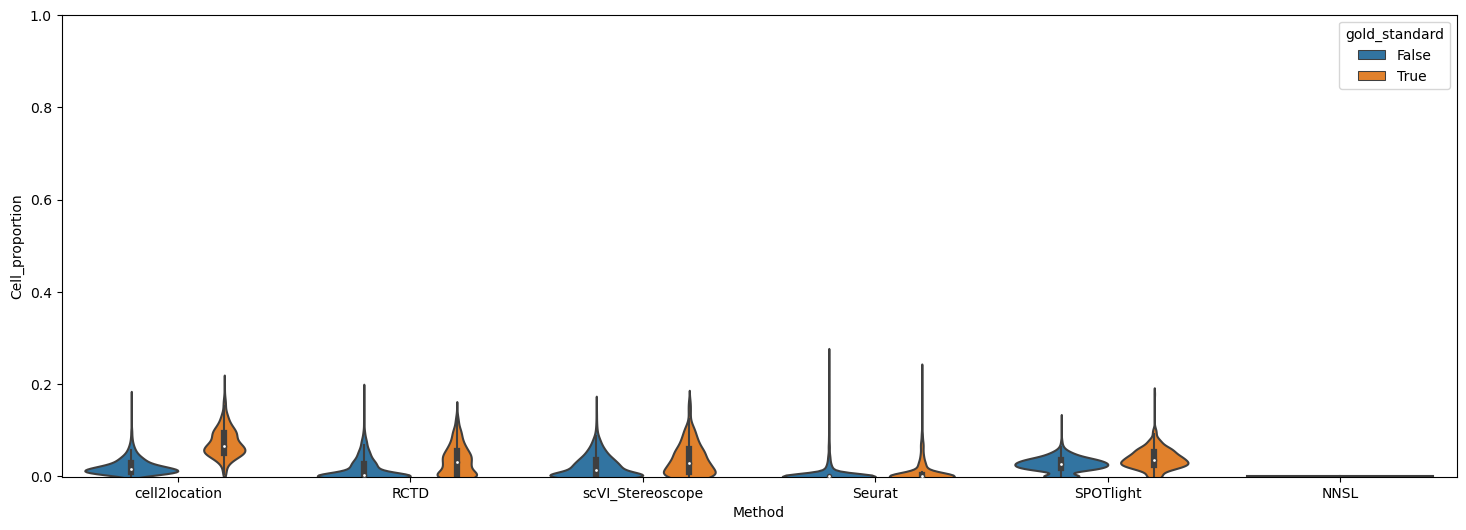

,cell2location,RCTD,scVI_Stereoscope,Seurat,SPOTlight,NNSL
pvalue,0.000000,0.000000,0.000000,0.000023,0.000000,NaN
mean_GC,0.073010,0.035850,0.038241,0.010580,0.038281,0.0
mean_nonGC,0.021877,0.016373,0.021707,0.006065,0.026461,0.0
fold_change,3.337343,2.189523,1.761713,1.744236,1.446679,NaN
mean_greater_than_0.055_GC,0.671958,0.251323,0.275132,0.066138,0.208995,0.0
mean_greater_than_0.055_nonGC,0.055023,0.082124,0.107857,0.032028,0.031755,0.0
sum_greater_than_0.055_GC,254.000000,95.000000,104.000000,25.000000,79.000000,0.0
sum_greater_than_0.055_nonGC,201.000000,300.000000,394.000000,117.000000,116.000000,0.0
greater_than_0.055_FC,12.212246,3.060273,2.550909,2.064962,6.581532,NaN


In [18]:
# save combined object
fig2k = pd.DataFrame()
selected = ['T_CD4+_TfH_GC']
fig2k['gold_standard'] = pos_cell_count[:, results[0].columns.isin(selected)].flatten()

for i,n in enumerate(names):
    fig2k[n] = results[i].values[:, results[0].columns.isin(selected)].flatten()
    
fig2k_melt = fig2k.melt(id_vars='gold_standard', var_name='Method', value_name='Cell_proportion')

plt.figure(figsize=(18, 6))
import seaborn as sns
#ax = sns.swarmplot(x="Method", y="Cell_proportion", hue="gold_standard", data=fig2k_melt, dodge=True,
#                  hue_order=[False, True], size=2.5, color='grey')

ax = sns.violinplot(x="Method", y="Cell_proportion", hue="gold_standard", data=fig2k_melt, dodge=True,
                  hue_order=[False, True], inner='box', bw=0.3)
plt.ylim(-0.001, 1.001);
plt.show()

import scipy
ttest = {n: [scipy.stats.ttest_ind(fig2k.loc[fig2k['gold_standard'] != True, n].values, 
                      fig2k.loc[fig2k['gold_standard'] == True, n].values,
                       alternative='less')[1], 
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values),
             np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values), 
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values) \
             / np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values), 
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values > 0.055),
             np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values > 0.055),
             np.sum(fig2k.loc[fig2k['gold_standard'] == True, n].values > 0.055),
             np.sum(fig2k.loc[fig2k['gold_standard'] != True, n].values > 0.055),
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values > 0.055)\
             / np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values > 0.055)]
            for n in names}
ttest = pd.DataFrame(ttest, index=['pvalue', 'mean_GC', 'mean_nonGC', 'fold_change', 
                           'mean_greater_than_0.055_GC', 'mean_greater_than_0.055_nonGC',
                           'sum_greater_than_0.055_GC', 'sum_greater_than_0.055_nonGC',
                           'greater_than_0.055_FC']).round(10)
ttest

In [19]:
p_sel = pd.crosstab(fig2k['gold_standard'], fig2k['cell2location'] > 0.055, margins=True)
p_sel, p_sel[True][1.0] / p_sel['All'][1.0], p_sel[True][1.0] / p_sel[True]['All']

(cell2location  False  True   All
 gold_standard                   
 0.0             3452   201  3653
 1.0              124   254   378
 All             3576   455  4031,
 0.671957671957672,
 0.5582417582417583)

In [20]:
sum_ratio = (ttest.loc['sum_greater_than_0.055_nonGC'])/ttest.loc['sum_greater_than_0.055_GC']
sum_ratio

cell2location       0.791339
RCTD                3.157895
scVI_Stereoscope    3.788462
Seurat              4.680000
SPOTlight           1.468354
NNSL                     NaN
dtype: float64

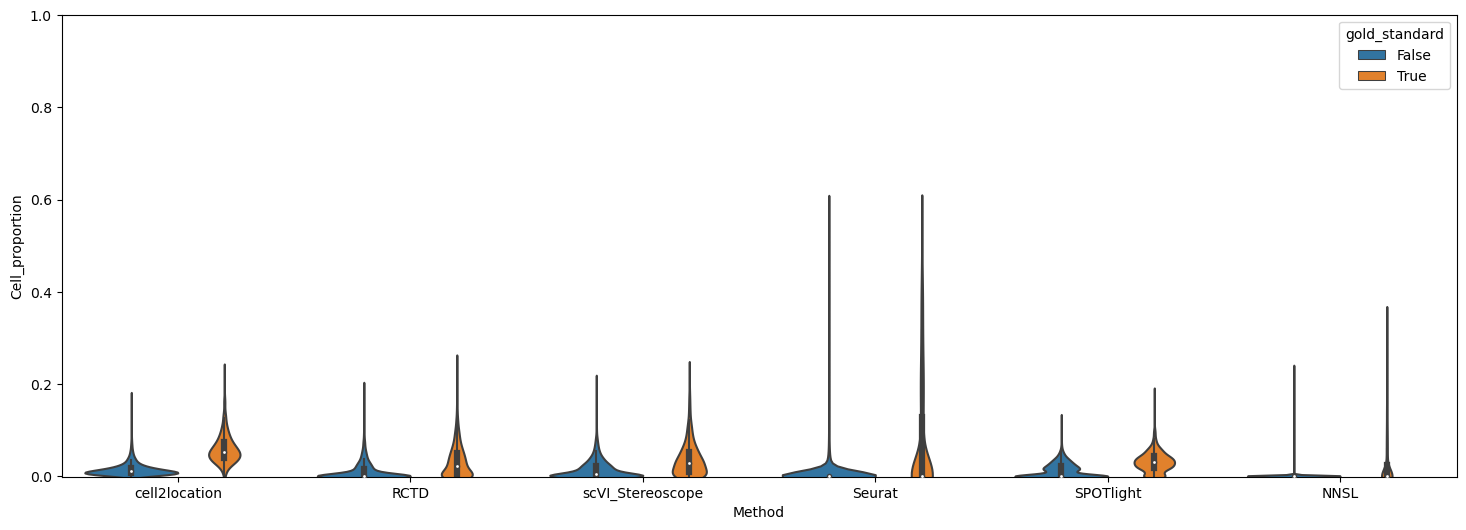

,cell2location,RCTD,scVI_Stereoscope,Seurat,SPOTlight,NNSL
pvalue,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean_GC,0.059914,0.032314,0.037246,0.074960,0.031170,0.025344
mean_nonGC,0.014646,0.010364,0.013954,0.006969,0.012255,0.000560
fold_change,4.090716,3.117863,2.669149,10.756613,2.543438,45.222397
mean_greater_than_0.031_GC,0.873016,0.415344,0.458554,0.336861,0.491182,0.241623
mean_greater_than_0.031_nonGC,0.096359,0.118076,0.159047,0.047085,0.133589,0.006387
sum_greater_than_0.031_GC,990.000000,471.000000,520.000000,382.000000,557.000000,274.000000
sum_greater_than_0.031_nonGC,1056.000000,1294.000000,1743.000000,516.000000,1464.000000,70.000000
greater_than_0.031_FC,9.060020,3.517584,2.883127,7.154372,3.676817,37.827740


In [21]:
# save combined object
fig2k = pd.DataFrame()
selected = ['T_CD4+_TfH_GC', 'B_GC_prePB', 'B_GC_DZ']
fig2k['gold_standard'] = pos_cell_count[:, results[0].columns.isin(selected)].flatten()

for i,n in enumerate(names):
    fig2k[n] = results[i].values[:, results[0].columns.isin(selected)].flatten()
    
fig2k_melt = fig2k.melt(id_vars='gold_standard', var_name='Method', value_name='Cell_proportion')

plt.figure(figsize=(18, 6))
import seaborn as sns
#ax = sns.swarmplot(x="Method", y="Cell_proportion", hue="gold_standard", data=fig2k_melt, dodge=True,
#                  hue_order=[False, True], size=2.5, color='grey')

ax = sns.violinplot(x="Method", y="Cell_proportion", hue="gold_standard", data=fig2k_melt, dodge=True,
                  hue_order=[False, True], inner='box', bw=0.3)
plt.ylim(-0.001, 1.001);
plt.show()

import scipy
ttest = {n: [scipy.stats.ttest_ind(fig2k.loc[fig2k['gold_standard'] != True, n].values, 
                      fig2k.loc[fig2k['gold_standard'] == True, n].values,
                       alternative='less')[1], 
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values),
             np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values), 
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values) \
             / np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values), 
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values > 0.031),
             np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values > 0.031),
             np.sum(fig2k.loc[fig2k['gold_standard'] == True, n].values > 0.031),
             np.sum(fig2k.loc[fig2k['gold_standard'] != True, n].values > 0.031),
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values > 0.031)\
             / np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values > 0.031)]
            for n in names}
ttest = pd.DataFrame(ttest, index=['pvalue', 'mean_GC', 'mean_nonGC', 'fold_change', 
                           'mean_greater_than_0.031_GC', 'mean_greater_than_0.031_nonGC',
                           'sum_greater_than_0.031_GC', 'sum_greater_than_0.031_nonGC',
                           'greater_than_0.031_FC']).round(10)
ttest

In [22]:
# how many times more locations are outside GC?
sum_ratio = (ttest.loc['sum_greater_than_0.031_nonGC'])/ttest.loc['sum_greater_than_0.031_GC']
sum_ratio

cell2location       1.066667
RCTD                2.747346
scVI_Stereoscope    3.351923
Seurat              1.350785
SPOTlight           2.628366
NNSL                0.255474
dtype: float64

In [23]:
# the above normalised by corresponding value from cell2location
sum_ratio / sum_ratio['cell2location']

cell2location       1.000000
RCTD                2.575637
scVI_Stereoscope    3.142428
Seurat              1.266361
SPOTlight           2.464093
NNSL                0.239507
dtype: float64

In [24]:
# average across methods
(sum_ratio / sum_ratio['cell2location'])[['RCTD', 'scVI_Stereoscope', 'Seurat', 'SPOTlight']].mean()

2.3621298602765353

In [25]:
# contingency table at this threshold
p_sel = pd.crosstab(fig2k['gold_standard'], fig2k['cell2location'] > 0.031, margins=True)
# Recall/TPR, Precision
p_sel, p_sel[True][1.0] / p_sel['All'][1.0], p_sel[True][1.0] / p_sel[True]['All']

(cell2location  False  True    All
 gold_standard                    
 0.0             9903  1056  10959
 1.0              144   990   1134
 All            10047  2046  12093,
 0.873015873015873,
 0.4838709677419355)

In [26]:
import scipy
mannwhitneyu = {n: [scipy.stats.mannwhitneyu(fig2k.loc[fig2k['gold_standard'] != True, n].values, 
                      fig2k.loc[fig2k['gold_standard'] == True, n].values,
                       alternative='less')[1], 
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values) \
             / np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values),
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values > 0.05),
             np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values > 0.05)]
            for n in names}
pd.DataFrame(mannwhitneyu, index=['pvalue', 'fold_change',
                           'p_greater_than_05_GC', 'p_greater_than_05_nonGC']).round(10)

,cell2location,RCTD,scVI_Stereoscope,Seurat,SPOTlight,NNSL
pvalue,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fold_change,4.090716,3.117863,2.669149,10.756613,2.543438,45.222397
p_greater_than_05_GC,0.557319,0.252205,0.282187,0.311287,0.171958,0.200176
p_greater_than_05_nonGC,0.029930,0.049275,0.060224,0.032485,0.021352,0.003376


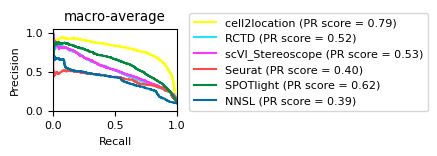

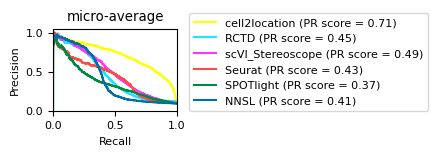

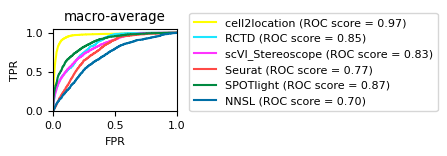

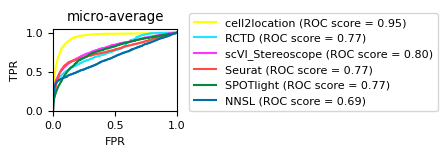

In [27]:
mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (1.6, 1.3), 'font.size': 8}):
    
    for c in ['PR', 'ROC']:
        for m in ['macro', 'micro']:
            compare_precision_recall(pos_cell_count, results,
                                     method_title=names, 
                                     legend_loc=(1.1, 0),
                                     mode=m, curve=c,
                                     font_size=mpl.rcParams['font.size'], lw=1.5)
                                     #colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
            plt.tight_layout()
            plt.title(f'{m}-average')
            #plt.savefig(f'{fig_path}/{c}_comparison_all_{m}average.pdf', bbox_inches='tight')
            plt.show()

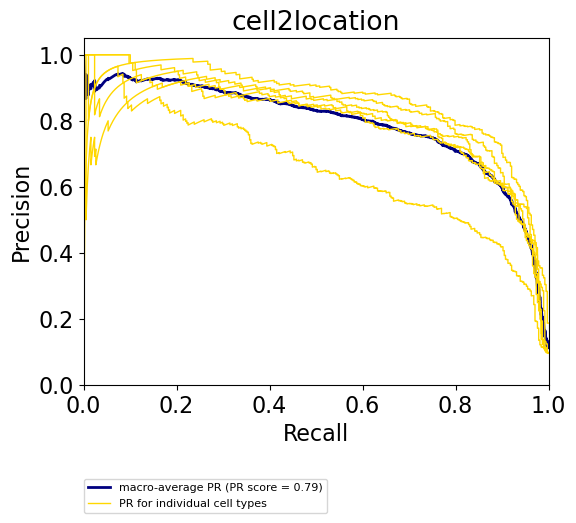

In [28]:
mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (6,5.5), 'font.size': 16}):
    plot_precision_recall(pos_cell_count, results[0], title=names[0])

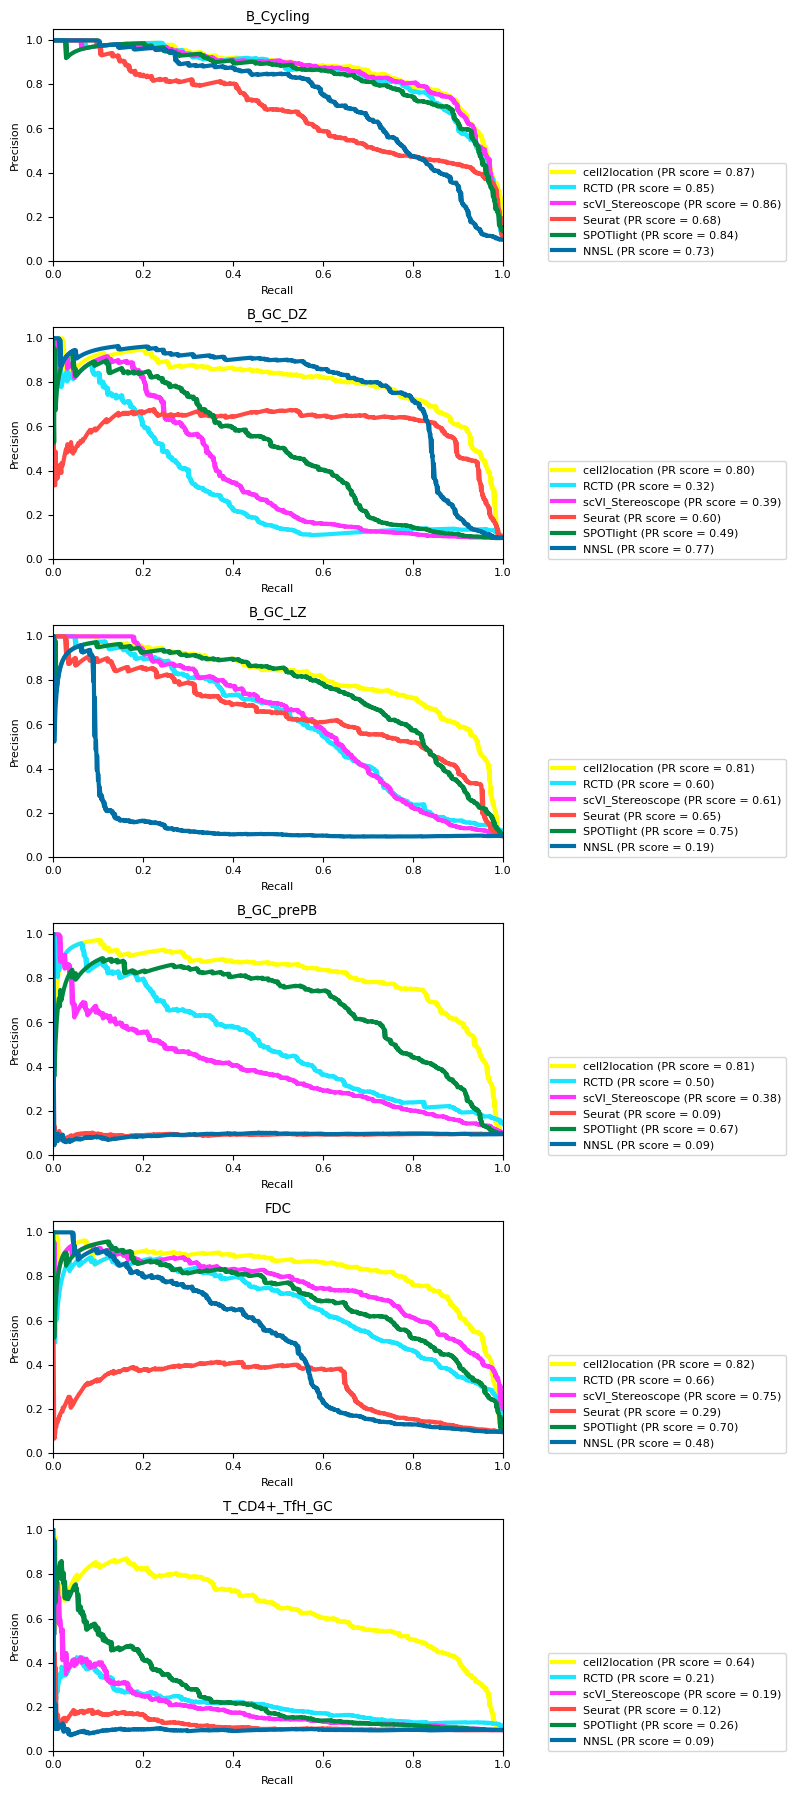

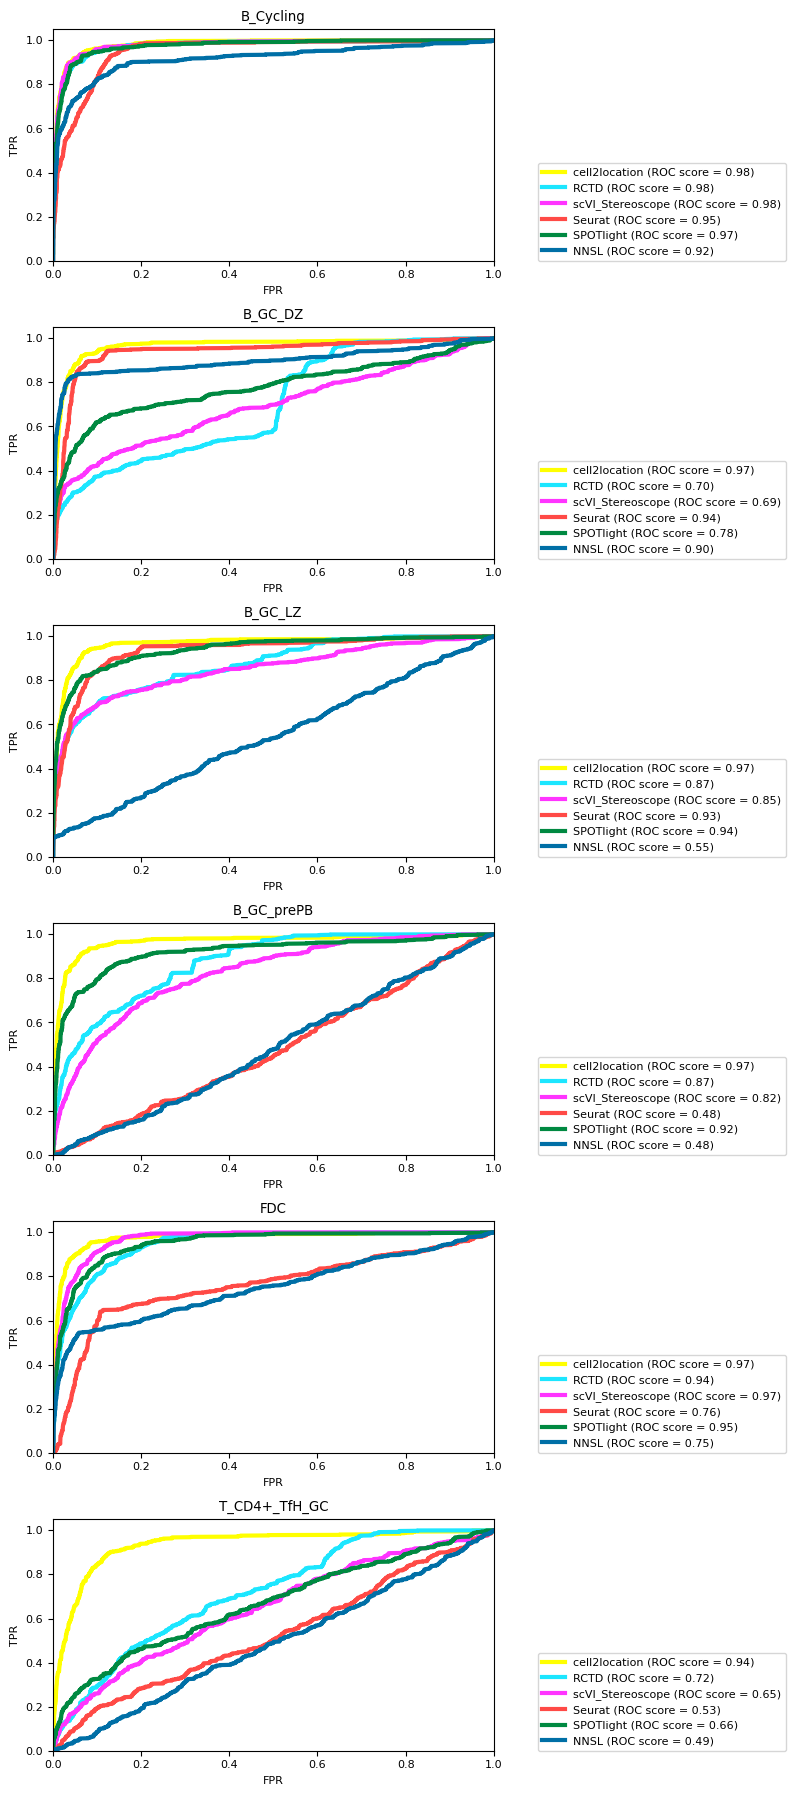

In [29]:
mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (8,18), 'font.size': 8}):

    for c in ['PR', 'ROC']:
        for i, ct in enumerate(col_ind):

            plt.subplot(len(col_ind), 1, i+1)
            compare_precision_recall(pos_cell_count[:, np.isin(col_ind, ct)].reshape((pos_cell_count.shape[0], 1)), 
                                     [i[[ct]] for i in results],
                                     method_title=names, 
                                     legend_loc=(1.1, 0),
                                     curve=c,
                                     font_size=8
                                     #colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']
                                    )
            plt.tight_layout()
            plt.title(f'{ct}')
        plt.savefig(f'{fig_path}/{c}_comparison_all_cell_types.pdf', bbox_inches='tight')
        plt.show()

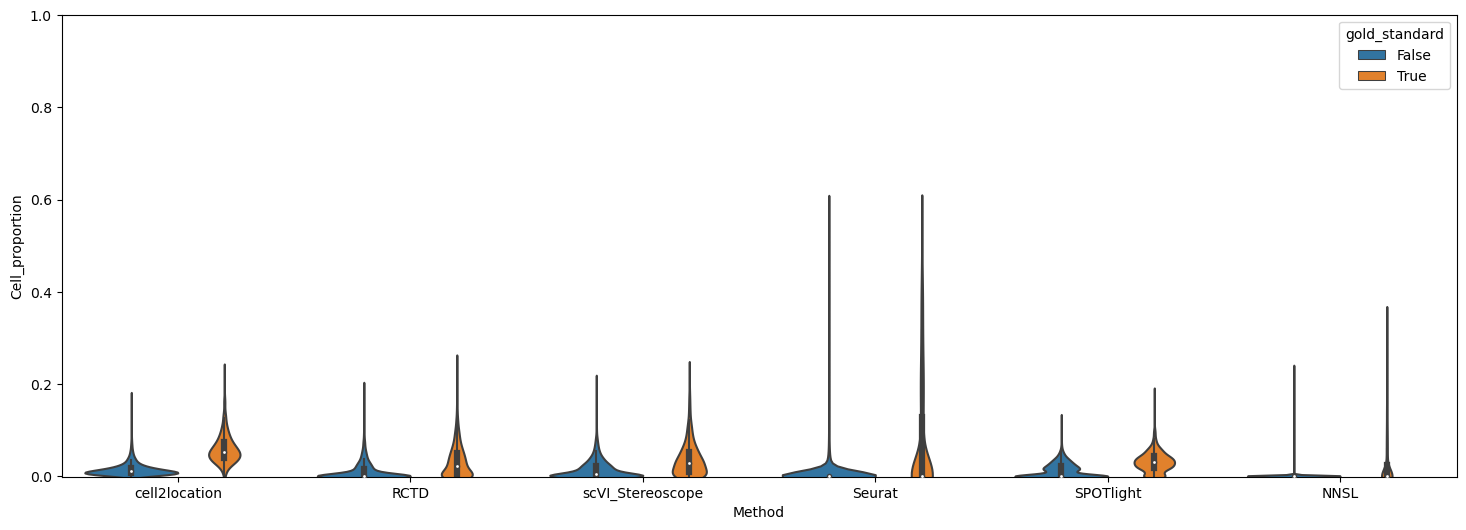

,cell2location,RCTD,scVI_Stereoscope,Seurat,SPOTlight,NNSL
pvalue,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean_GC,0.059914,0.032314,0.037246,0.074960,0.031170,0.025344
mean_nonGC,0.014646,0.010364,0.013954,0.006969,0.012255,0.000560
fold_change,4.090716,3.117863,2.669149,10.756613,2.543438,45.222397
mean_greater_than_threshold_GC,0.101411,0.055556,0.072310,0.273369,0.004409,0.107584
mean_greater_than_threshold_nonGC,0.001734,0.002920,0.003467,0.019984,0.000365,0.001004
sum_greater_than_threshold_GC,115.000000,63.000000,82.000000,310.000000,5.000000,122.000000
sum_greater_than_threshold_nonGC,19.000000,32.000000,38.000000,219.000000,4.000000,11.000000
greater_than_threshold_FC,58.492760,19.026042,20.853940,13.679665,12.080026,107.182780


In [30]:
# save combined object
fig2k = pd.DataFrame()
selected = ['T_CD4+_TfH_GC', 'B_GC_prePB', 'B_GC_DZ']
fig2k['gold_standard'] = pos_cell_count[:, results[0].columns.isin(selected)].flatten()
thresholds = {n: 0.1 for n in names}

for i,n in enumerate(names):
    fig2k[n] = results[i].values[:, results[0].columns.isin(selected)].flatten()
    
fig2k_melt = fig2k.melt(id_vars='gold_standard', var_name='Method', value_name='Cell_proportion')

plt.figure(figsize=(18, 6))
import seaborn as sns
#ax = sns.swarmplot(x="Method", y="Cell_proportion", hue="gold_standard", data=fig2k_melt, dodge=True,
#                  hue_order=[False, True], size=2.5, color='grey')

ax = sns.violinplot(x="Method", y="Cell_proportion", hue="gold_standard", data=fig2k_melt, dodge=True,
                  hue_order=[False, True], inner='box', bw=0.3)
plt.ylim(-0.001, 1.001);
plt.show()

import scipy
ttest = {n: [scipy.stats.ttest_ind(fig2k.loc[fig2k['gold_standard'] != True, n].values, 
                      fig2k.loc[fig2k['gold_standard'] == True, n].values,
                       alternative='less')[1], 
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values),
             np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values), 
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values) \
             / np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values), 
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values > thresholds[n]),
             np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values > thresholds[n]),
             np.sum(fig2k.loc[fig2k['gold_standard'] == True, n].values > thresholds[n]),
             np.sum(fig2k.loc[fig2k['gold_standard'] != True, n].values > thresholds[n]),
             np.mean(fig2k.loc[fig2k['gold_standard'] == True, n].values > thresholds[n])\
             / np.mean(fig2k.loc[fig2k['gold_standard'] != True, n].values > thresholds[n])]
            for n in names}
ttest = pd.DataFrame(ttest, index=['pvalue', 'mean_GC', 'mean_nonGC', 'fold_change', 
                           'mean_greater_than_threshold_GC', 'mean_greater_than_threshold_nonGC',
                           'sum_greater_than_threshold_GC', 'sum_greater_than_threshold_nonGC',
                           'greater_than_threshold_FC']).round(10)
ttest

## Bar plot by cell type

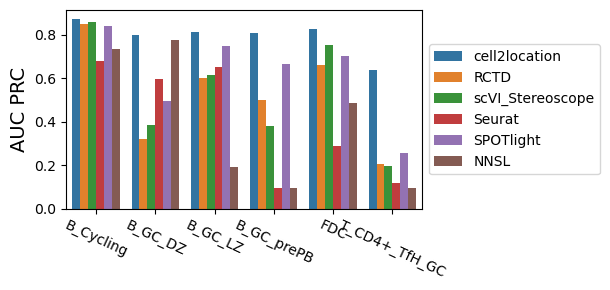

In [31]:
def get_stat_for_types_generic(cell_count, infer_cell_count, calculate_stat):
    max_val = np.array([cell_count.max(), infer_cell_count.values.max()]).max()
    if max_val < 1:
        max_val = 1
    
    types_data = {}
    for i, c in enumerate(infer_cell_count.columns): 
        types_data[c] = calculate_stat(cell_count[:,[i]], infer_cell_count.loc[:,[c]])
    return pd.DataFrame(types_data, index=[1])

from functools import partial
get_PR = lambda x, y: compute_precision_recall(x, y, mode='macro')[2]['averaged']

get_PR_df_short = partial(get_stat_for_types_generic, cell_count=pos_cell_count,
                          calculate_stat=get_PR)

pr_data = pd.concat([get_PR_df_short(infer_cell_count=df) for df in results])
pr_data['method'] = names
pr_data_melted = pd.melt(pr_data, id_vars=['method'], value_vars=pr_data.columns[:-1])

plt.figure(figsize=(6.2, 3.))
g = sns.barplot(x="variable", y="value",
                hue="method",
                data=pr_data_melted);

plt.xlabel('');
plt.ylabel('AUC PRC', size=14);
plt.xticks(size=10, rotation=-25, ha='center');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.tight_layout();

# plt.savefig(fig_path + '/barplot_by_category_with_label.pdf', bbox_inches='tight')

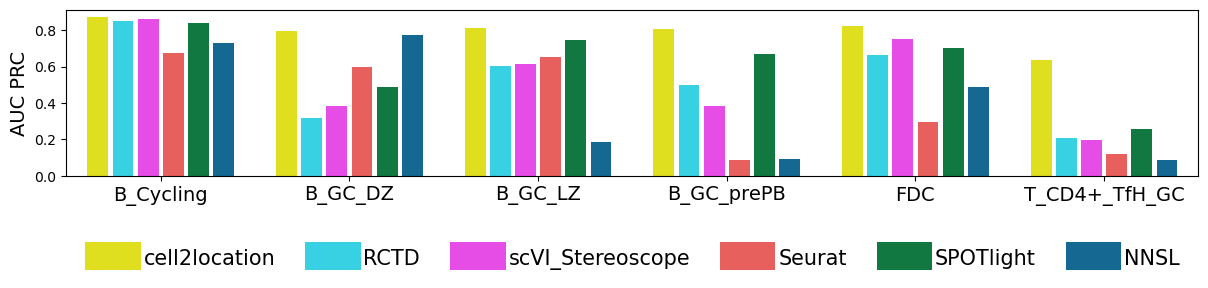

In [32]:
def get_stat_for_types_generic(cell_count, infer_cell_count, calculate_stat):
    max_val = np.array([cell_count.max(), infer_cell_count.values.max()]).max()
    if max_val < 1:
        max_val = 1
    
    types_data = {}
    for i, c in enumerate(infer_cell_count.columns): 
        types_data[c] = calculate_stat(cell_count[:,[i]], infer_cell_count.loc[:,[c]])
    return pd.DataFrame(types_data, index=[1])

from functools import partial
get_PR = lambda x, y: compute_precision_recall(x, y, mode='macro')[2]['averaged']

get_PR_df_short = partial(get_stat_for_types_generic, cell_count=pos_cell_count,
                          calculate_stat=get_PR)

pr_data = pd.concat([get_PR_df_short(infer_cell_count=df) for df in results])
pr_data['method'] = names
pr_data_melted = pd.melt(pr_data, id_vars=['method'], value_vars=pr_data.columns[:-1])

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

plt.figure(figsize=(12.2, 3.5))
g = sns.barplot(x="variable", y="value",
                hue="method",
                data=pr_data_melted, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('AUC PRC', size=14);
plt.xticks(size=14, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.65,  1, 0.3), mode='expand', ncol=6, 
           fontsize=15, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(20)
    handle.set_width(40)
    handle.set_y(-4)
plt.tight_layout();

#plt.savefig('suffer' + '/barplot_PR_big.pdf', bbox_inches='tight')

# plt.savefig(fig_path + '/barplot_by_category_with_label.pdf', bbox_inches='tight')

## Bar plot separating cell types by abundance

In [33]:
design = pd.DataFrame(index=results[1].columns)
design['is_high_density'] = 1
design.loc[design.index == 'B_GC_prePB', 'is_high_density'] = 0
design.loc[design.index == 'T_CD4+_TfH_GC', 'is_high_density'] = 0
design

,is_high_density
B_Cycling,1
B_GC_DZ,1
B_GC_LZ,1
B_GC_prePB,0
FDC,1
T_CD4+_TfH_GC,0


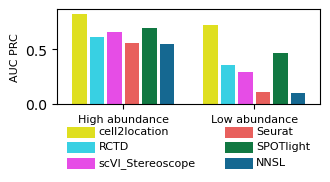

In [34]:
def get_stat_for_types_generic(cell_count, infer_cell_count, design, calculate_stat):
    design_loc = design.loc[infer_cell_count.columns,:]
    max_val = np.array([cell_count.max(), infer_cell_count.values.max()]).max()
    if max_val < 1:
        max_val = 1
    
    types_data = {}
    ind = design_loc['is_high_density'].values.astype(bool)
    types_data['High abundance'] = calculate_stat(cell_count[:,ind], infer_cell_count.loc[:,ind])
    
    ind = ~ design_loc['is_high_density'].values.astype(bool)
    types_data['Low abundance'] = calculate_stat(cell_count[:,ind], infer_cell_count.loc[:,ind])
    
    return pd.DataFrame(types_data, index=[1])

from functools import partial
get_PR = lambda x, y: compute_precision_recall(x, y, mode='macro')[2]['averaged']

get_PR_df_short = partial(get_stat_for_types_generic, cell_count=pos_cell_count,
                          design=design,
                          calculate_stat=get_PR)

pr_data = pd.concat([get_PR_df_short(infer_cell_count=df) for df in results])
pr_data['method'] = names
pr_data_melted = pd.melt(pr_data, id_vars=['method'], value_vars=pr_data.columns[:-1])

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

plt.figure(figsize=(3.4, 2.3))
g = sns.barplot(x="variable", y="value",
                hue="method",
                data=pr_data_melted, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('AUC PRC', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();

#plt.savefig('suffer' + '/barplot_PR_big.pdf', bbox_inches='tight')

plt.savefig(fig_path + '/barplot_by_category_with_label.pdf', bbox_inches='tight')

## Bar plot separating cell types by txn distinctiveness

T_CD4+_TfH_GC         18.941714
T_TfR                 18.941714
T_Treg                22.390637
T_CD8+_CD161+         22.390637
T_CD4+_naive          22.894105
T_CD8+_naive          22.894105
B_activated           25.610257
B_naive               25.610257
T_CD4+                31.285434
B_IFN                 40.232412
B_preGC               41.574471
B_mem                 41.914312
ILC                   43.090393
T_CD4+_TfH            48.009632
T_CD8+_cytotoxic      49.974831
NK                    52.497701
NKT                   56.837097
B_GC_prePB            60.824334
B_GC_LZ               60.824334
B_GC_DZ               61.137554
Macrophages_M1        63.118846
Macrophages_M2        63.118846
DC_pDC                71.546903
Mast                  77.778779
VSMC                  95.417814
Endo                  98.349150
T_TIM3+              101.963067
Monocytes            104.407100
FDC                  111.295221
DC_cDC1              132.892391
B_Cycling            135.029961
DC_CCR7+

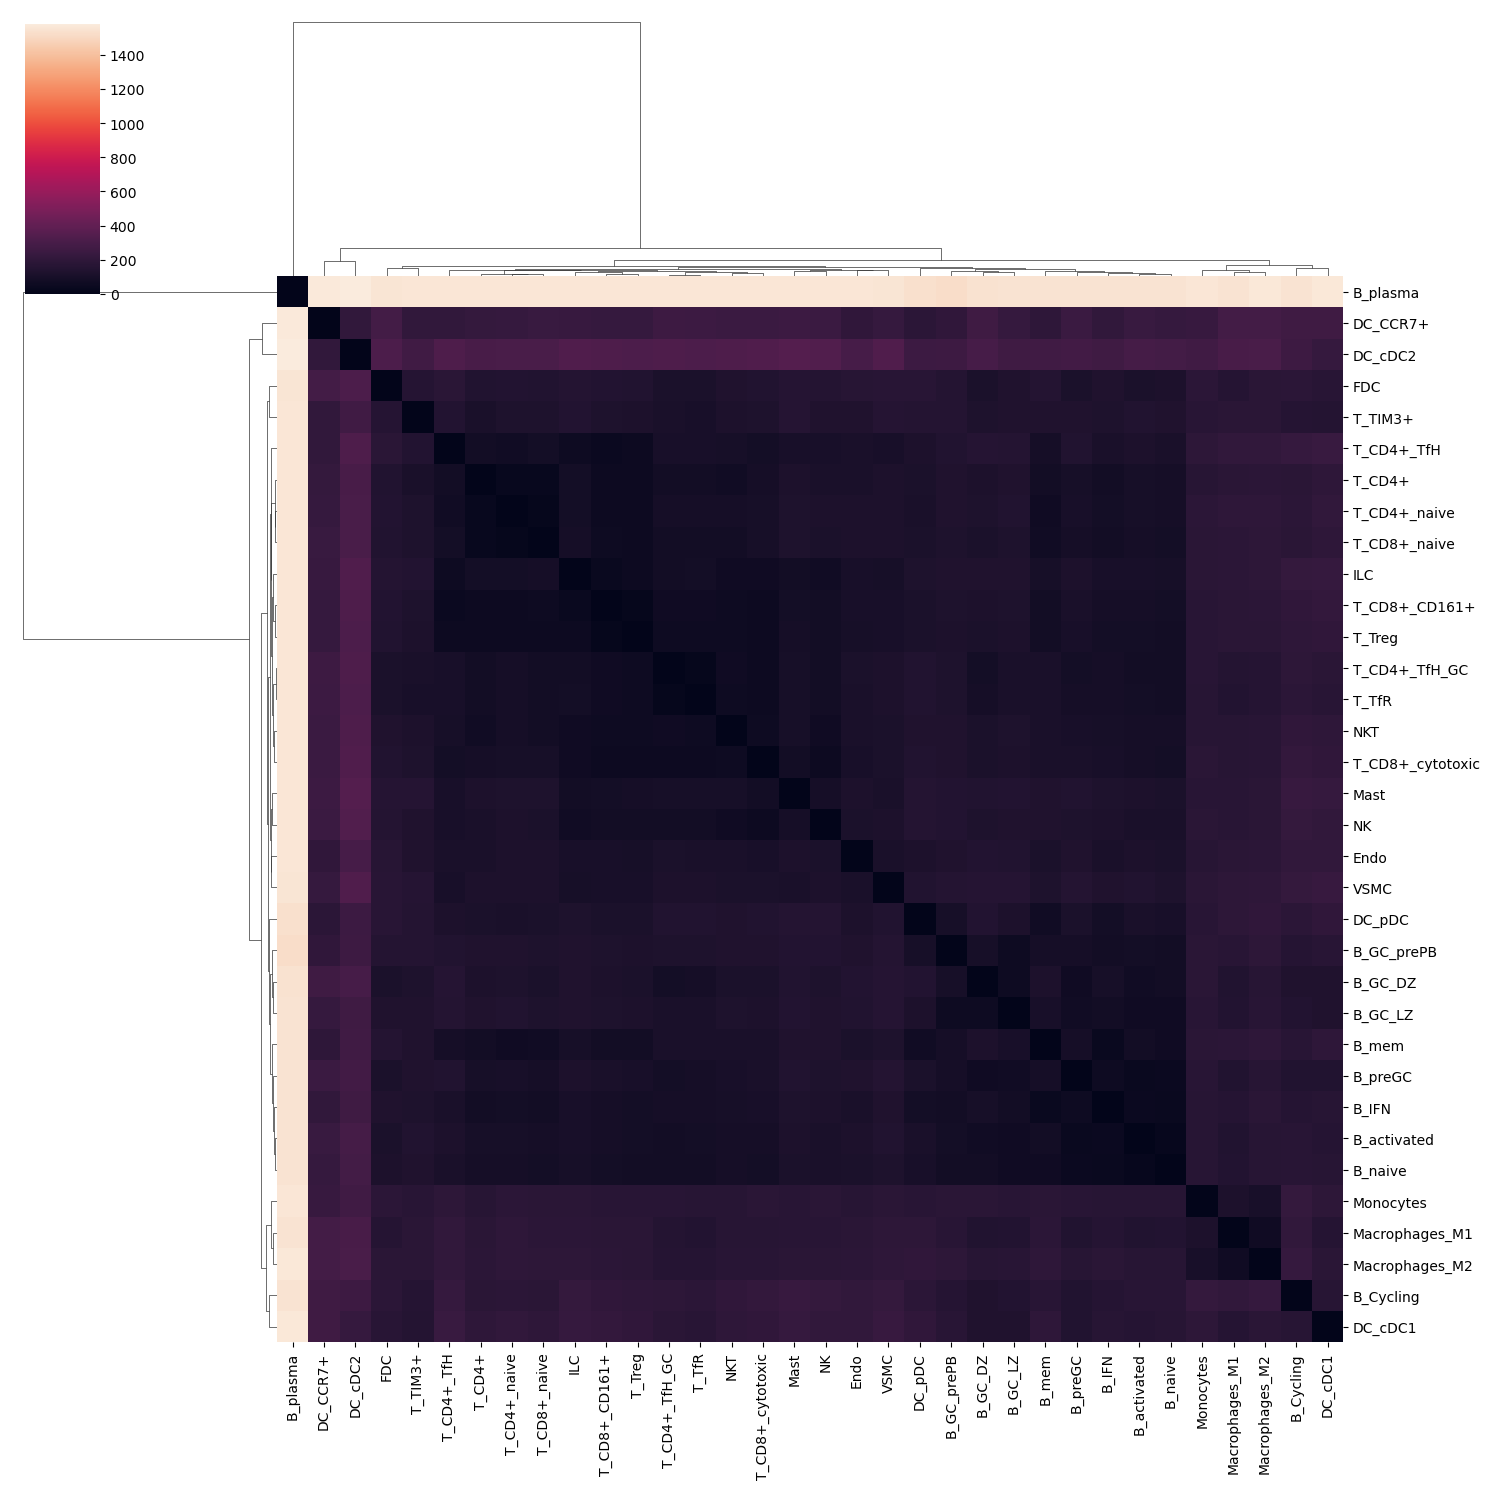

In [35]:
from scipy.spatial.distance import cdist

ct_dist = cdist(regr_inf_aver.T, regr_inf_aver.T, metric='euclidean')
ct_dist = pd.DataFrame(ct_dist, index=regr_inf_aver.columns, columns=regr_inf_aver.columns)

sns.clustermap(ct_dist, figsize=(15, 15))

distinctiveness = pd.DataFrame(np.array(
    [[ct_dist[c].sort_values()[1:4].mean() for c in ct_dist.columns],
     [ct_dist[c].sort_values()[1].mean() for c in ct_dist.columns]]
).T,
             index=ct_dist.columns, columns=['top3_average_distance', 'min_distance'])

distinctiveness['min_distance'].sort_values()

In [36]:
distinctiveness['min_distance'][results[1].columns].sort_values()

T_CD4+_TfH_GC     18.941714
B_GC_LZ           60.824334
B_GC_prePB        60.824334
B_GC_DZ           61.137554
FDC              111.295221
B_Cycling        135.029961
Name: min_distance, dtype: float64

In [37]:
design = pd.DataFrame(index=results[1].columns)

design['is_txn_fine'] = 1
design.loc[design.index == 'FDC', 'is_txn_fine'] = 0
design.loc[design.index == 'B_Cycling', 'is_txn_fine'] = 0

design['is_high_density'] = 0
design.loc[design.index == 'B_Cycling', 'is_high_density'] = 1
design.loc[design.index == 'B_GC_DZ', 'is_high_density'] = 1
design.loc[design.index == 'B_GC_LZ', 'is_high_density'] = 1
design

,is_txn_fine,is_high_density
B_Cycling,0,1
B_GC_DZ,1,1
B_GC_LZ,1,1
B_GC_prePB,1,0
FDC,0,0
T_CD4+_TfH_GC,1,0


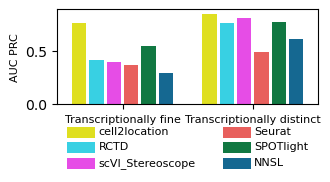

In [38]:
def get_stat_for_types_generic(cell_count, infer_cell_count, design, calculate_stat):
    design_loc = design.loc[infer_cell_count.columns,:]
    max_val = np.array([cell_count.max(), infer_cell_count.values.max()]).max()
    if max_val < 1:
        max_val = 1
    
    types_data = {}
    ind = design_loc['is_txn_fine'].values.astype(bool)
    types_data['Transcriptionally fine'] = calculate_stat(cell_count[:,ind], infer_cell_count.loc[:,ind])
    
    ind = ~ design_loc['is_txn_fine'].values.astype(bool)
    types_data['Transcriptionally distinct'] = calculate_stat(cell_count[:,ind], infer_cell_count.loc[:,ind])
    
    return pd.DataFrame(types_data, index=[1])

from functools import partial
get_PR = lambda x, y: compute_precision_recall(x, y, mode='macro')[2]['averaged']

get_PR_df_short = partial(get_stat_for_types_generic, cell_count=pos_cell_count,
                          design=design,
                          calculate_stat=get_PR)

pr_data = pd.concat([get_PR_df_short(infer_cell_count=df) for df in results])
pr_data['method'] = names
pr_data_melted = pd.melt(pr_data, id_vars=['method'], value_vars=pr_data.columns[:-1])

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

plt.figure(figsize=(3.4, 2.3))
g = sns.barplot(x="variable", y="value",
                hue="method",
                data=pr_data_melted, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('AUC PRC', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();

#plt.savefig('suffer' + '/barplot_PR_big.pdf', bbox_inches='tight')

plt.savefig(fig_path + '/barplot_by_category_txn_distinct_with_label.pdf', bbox_inches='tight')

In [39]:
fig_path

'/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/scvi/external/cell2location/tutorial/results/lymph_nodes_analysis/non_amortised/signatures_lr0002_Adam_20kiter_c2l//plots/figures/'

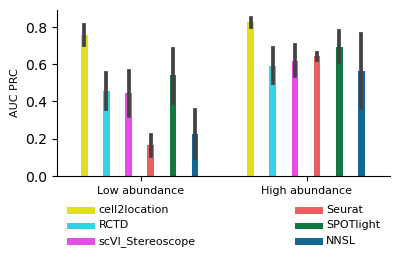

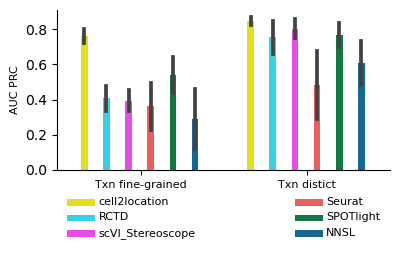

In [40]:
def remove_avg(d):
    d.pop('averaged')
    return d

def change_width(ax, new_value, shrink=0, shift=0):
    """
    Change width/position of barplots 
    """
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        patch.set_x(patch.get_x() + shrink * (patch.get_x() - patch.get_x() - shift))
        
    for patch in ax.lines:
        patch.set_xdata(patch.get_xdata() + shrink * (patch.get_xdata() - patch.get_xdata() - shift))

get_PR_values = lambda x, y: list(remove_avg(compute_precision_recall(x, y, mode='macro')[2]).values())

get_PR_df_short = partial(get_stat_for_types_generic, cell_count=pos_cell_count,
                          design=design,
                          calculate_stat=get_PR_values)

dfs_detailed = []
for df, method in zip(results, names):
    df_detailed = pd.DataFrame({'value': get_PR_values(pos_cell_count, df)})
    df_detailed['cell_type'] = df.columns
    df_detailed['is_high_density'] = design['is_high_density'][df.columns].values
    df_detailed['is_txn_fine'] = design['is_txn_fine'][df.columns].values
    df_detailed['method'] = method
    
    dfs_detailed.append(df_detailed)
pr_data_values = pd.concat(dfs_detailed)

pr_data_values['Fig4_abundance_categories'] = ''
pr_data_values.loc[pr_data_values['is_high_density'] == 0, 'Fig4_abundance_categories'] = \
'Low abundance'
pr_data_values.loc[pr_data_values['is_high_density'] == 1, 'Fig4_abundance_categories'] = \
'High abundance'
pr_data_values['Fig4_abundance_categories'] = pr_data_values['Fig4_abundance_categories'].astype('category')
pr_data_values['Fig4_abundance_categories'] = pr_data_values['Fig4_abundance_categories'].cat.reorder_categories([
    'Low abundance', 'High abundance'
])

pr_data_values['Fig4_txn_categories'] = ''
pr_data_values.loc[pr_data_values['is_txn_fine'] == 1, 'Fig4_txn_categories'] = \
'Txn fine-grained'
pr_data_values.loc[pr_data_values['is_txn_fine'] == 0, 'Fig4_txn_categories'] = \
'Txn distict'
pr_data_values['Fig4_txn_categories'] = pr_data_values['Fig4_txn_categories'].astype('category')
pr_data_values['Fig4_txn_categories'] = pr_data_values['Fig4_txn_categories'].cat.reorder_categories([
    'Txn fine-grained', 'Txn distict'
])

def plot_boxplot_prc(x, y="value", n_leged_col=6):
    #g = sns.boxplot(x=x, y=y,
    #                hue="method",
    #                data=pr_data_values, palette=sc.pl.palettes.default_102);
    g = sns.barplot(x=x, y=y,
                    hue="method", ci=68,
                    data=pr_data_values, palette=sc.pl.palettes.default_102);
    
    change_width(g, .10)
    change_width(g, .04, shrink=0.55, shift=0.01)
    
    plt.xlabel('');
    plt.ylabel('AUC PRC', size=8);
    plt.xticks(size=8, ha='center');
    # lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), ncol=1, 
    #            fontsize=15, frameon=False);

    lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.45,  1, 0.3), 
                      mode='expand', ncol=n_leged_col, 
                      fontsize=8, frameon=False);

    for handle in lgnd.legendHandles:
         handle.set_height(5)
         handle.set_width(20)
         handle.set_y(-1)
    # plt.tight_layout();

    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
    plt.tight_layout();

    # ax = plt.gca()
    # ax.set_xticks(ax.get_xticks() + 0.4)
    # plt.savefig(fig_path + '/barplot_by_category_with_label.pdf', bbox_inches='tight')
    
plt.figure(figsize=(4.1, 2.88))
plot_boxplot_prc('Fig4_abundance_categories', n_leged_col=2)
plt.savefig(fig_path + '/barplot_Fig4_abundance_categories.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4.1, 2.8))
plot_boxplot_prc('Fig4_txn_categories', n_leged_col=2)
plt.savefig(fig_path + '/barplot_Fig4_txn_categories.pdf', bbox_inches='tight')
plt.show()

In [41]:
fig_path

'/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/scvi/external/cell2location/tutorial/results/lymph_nodes_analysis/non_amortised/signatures_lr0002_Adam_20kiter_c2l//plots/figures/'

## Plot PR, ROC and spatial maps for selected cell types

In [42]:
col_ind

['B_Cycling', 'B_GC_DZ', 'B_GC_LZ', 'B_GC_prePB', 'FDC', 'T_CD4+_TfH_GC']

In [43]:
ct_sel = col_ind

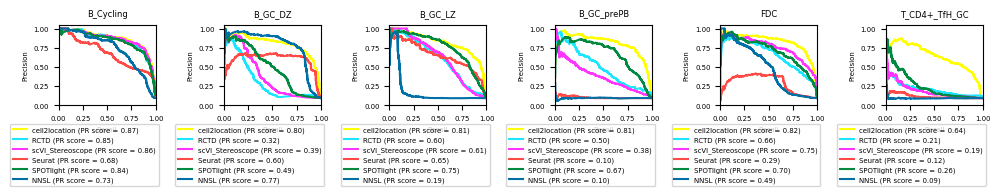

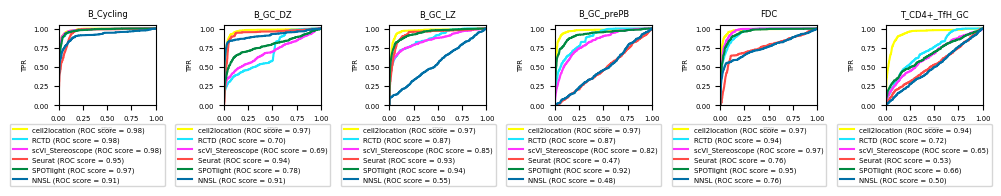

In [44]:
mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (10, 3), 'font.size': 5}):

    for c in ['PR', 'ROC']:
        for i, ct in enumerate(ct_sel):

            plt.subplot(1, len(ct_sel), i+1)
            compare_precision_recall(pos_cell_count[:, np.isin(col_ind, ct)].reshape((pos_cell_count.shape[0], 1)), 
                                     [i[[ct]] for i in results],
                                     method_title=names, 
                                     legend_loc=(-0.5, -1.0),
                                     curve=c,
                                     font_size=mpl.rcParams['font.size'], lw=1.5,
                                     #colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']
                                    )
            plt.title(f'{ct}')
        plt.tight_layout()
        plt.savefig(f'{fig_path}/{c}_comparison_selected_{ct_sel}_cell_types.pdf', bbox_inches='tight')
        plt.show()

In [45]:
fig_path

'/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/scvi/external/cell2location/tutorial/results/lymph_nodes_analysis/non_amortised/signatures_lr0002_Adam_20kiter_c2l//plots/figures/'

In [46]:
ct_sel = ['T_CD4+_TfH_GC']

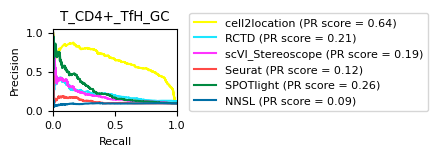

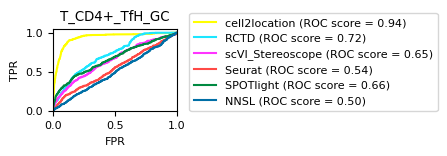

In [47]:
mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (1.6, 1.3), 'font.size': 8}):

    for c in ['PR', 'ROC']:
        for i, ct in enumerate(ct_sel):

            plt.subplot(len(ct_sel), 1, i+1)
            compare_precision_recall(pos_cell_count[:, np.isin(col_ind, ct)].reshape((pos_cell_count.shape[0], 1)), 
                                     [i[[ct]] for i in results],
                                     method_title=names, 
                                     legend_loc=(1.1, 0),
                                     curve=c,
                                     font_size=mpl.rcParams['font.size'], lw=1.5,
                                     #colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']
                                    )
            plt.title(f'{ct}')
        plt.tight_layout()
        plt.savefig(f'{fig_path}/{c}_comparison_selected_{ct_sel}_cell_types.pdf', bbox_inches='tight')
        plt.show()

In [48]:
ct_sel = ['T_CD4+_TfH_GC']

In [49]:
[f'{m}_{ct}' for ct in ct_sel for m in names]

['cell2location_T_CD4+_TfH_GC',
 'RCTD_T_CD4+_TfH_GC',
 'scVI_Stereoscope_T_CD4+_TfH_GC',
 'Seurat_T_CD4+_TfH_GC',
 'SPOTlight_T_CD4+_TfH_GC',
 'NNSL_T_CD4+_TfH_GC']

## Investigate txn differences between T_CD4+TfH & T_CD4+TfH_GC

Modules and their versions used for this analysis

In [50]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass


sys 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]
ipykernel 5.5.3
ipykernel._version 5.5.3
json 2.0.9
re 2.2.1
IPython 7.22.0
IPython.core.release 7.22.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.22.0
pygments 2.8.1
pexpect 4.8.0
ptyprocess 0.7.0
decorator 5.0.6
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.18
wcwidth 0.2.5
jedi 0.18.0
parso 0.8.2
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
IPython.core.magics.code 7.22.0
urllib.request 3.7
jupyter_client 6.1.12
jupyter_client._version 6.1.12
zmq 22.0.3
zmq.backend.cython 40304
zmq.backend.cython.constants 40304
zmq.sugar 22.0.3
zmq.sugar.constants 40304
zmq.sugar.version 22.0.3
jupyter_core 4.7.1
jupyter_core.version 4.7.1
tornado 6.1
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_de